### Steve's simple lag 

In [4]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import random
import math
from typing import Tuple, List

import numpy as np
import torch
from torch.optim import AdamW
import pandas as pd
from icecream import ic

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from darts.models import BlockRNNModel

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(seed)

Seed set to 42


42

Create funtions for making p and q

In [ ]:
def create_scaled_random_array(n_points: int) -> np.ndarray:
    """
    Creates a scaled random ndarray of shape (n_points, 1).

    Parameters:
    n_points (int): The number of points in the array.

    Returns:
    numpy.ndarray: A scaled random ndarray.
    """
    random_values = np.random.uniform(-1, 1, n_points).astype(np.float32)
    random_values[0] = 0.0
    return random_values


def create_simple_lagged_array(input_array: np.ndarray, lag: int) -> np.ndarray:
    """
    Creates a lagged version of the input array.

    Parameters:
    input_array (numpy.ndarray): The input array.
    lag (int): The lag to apply.

    Returns:
    numpy.ndarray: The lagged array.
    """
    lagged_array = np.zeros_like(input_array)
    n_points = len(input_array)
    for i in range(n_points - 1):
        if i + lag < 0:
            lagged_array[i] = input_array[0]
        elif i + lag >= n_points - 1:
            lagged_array[i] = input_array[i - 1]
        else:
            lagged_array[i] = input_array[i + lag]
    return lagged_array

def plot_p_q(p: np.ndarray, q: np.ndarray, title: str = "") -> None:
    """
    Plots two time series.

    Parameters:
    p (numpy.ndarray): The first time series.
    q (numpy.ndarray): The second time series.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    plt.plot(p, label="p")
    plt.plot(q, label="q")
    plt.title(title)
    plt.legend()
    plt.show()

plot p and q with lags of -1 and 1

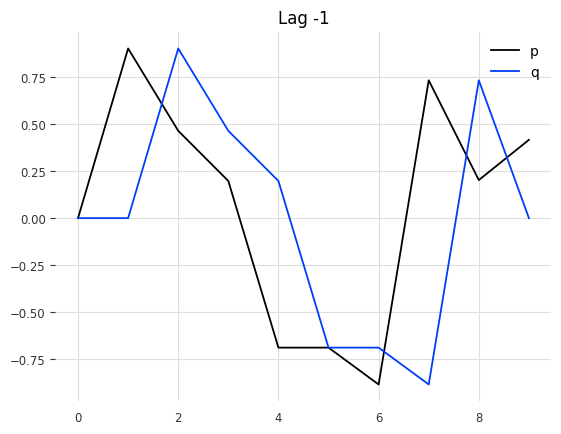

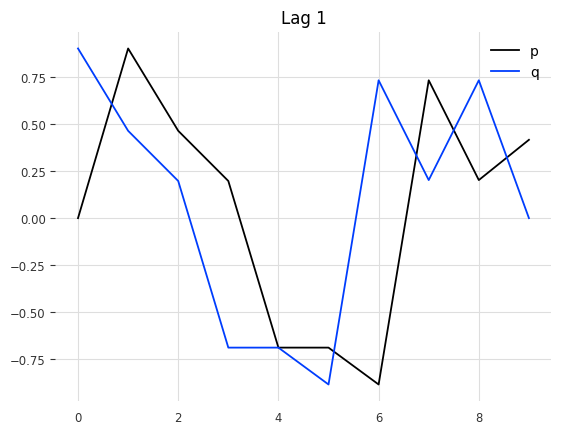

In [3]:
p = create_scaled_random_array(n_points=10)

q = create_simple_lagged_array(input_array=p, lag=-1)
plot_p_q(p, q, title="Lag -1")

q = create_simple_lagged_array(input_array=p, lag=1)
plot_p_q(p, q, title="Lag 1")

Create functions for making multiple p and corresponding q as Darts TimeSeries objects 

In [6]:
def create_multi_random_series(n_series: int, n_points: int) -> List[TimeSeries]:
    """
    Creates multiple random time series as Darts TimeSeries objects.

    Parameters:
    n_series (int): The number of time series to create.
    n_points (int): The number of points in each time series.

    Returns:
    list: A list of Darts TimeSeries objects, each representing a target time series.
    """    
    series_list = []
    for i in range(n_series):
        array = create_scaled_random_array(n_points=n_points)
        series_list.append(TimeSeries.from_values(array))
    return series_list


def create_multi_simple_lagged_series(target_series: List[TimeSeries], lag: int ) -> List[TimeSeries]:
    """
    Creates multiple lagged time series from the given target time series.

    Parameters:
    target_series (List[TimeSeries]): A list of Darts TimeSeries objects representing the target time series.
    lag (int): The lag to apply to each time series.

    Returns:
    List[TimeSeries]: A list of Darts TimeSeries objects, each representing a lagged time series.
    """    
    lagged_series = []
    for series in target_series:
        lagged_array = create_simple_lagged_array(input_array=series.values(), lag=lag)
        lagged_series.append(TimeSeries.from_values(lagged_array))
    return lagged_series

Make multiple target and corresponding lagged time series

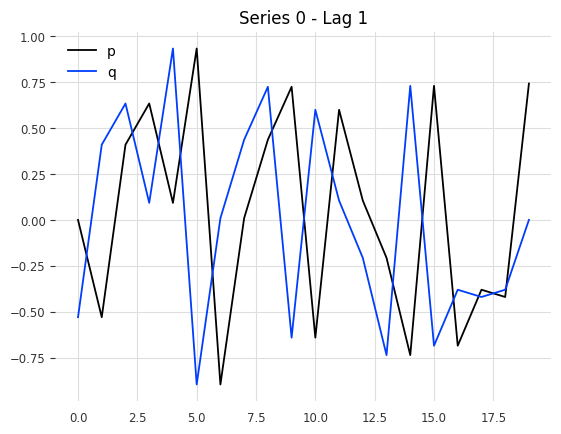

In [14]:
N_MULTI_SERIES = 36
TIME_SERIES_LEN = 20
LAG = 1

target_series = create_multi_random_series(n_series=N_MULTI_SERIES, n_points=TIME_SERIES_LEN)
lagged_series = create_multi_simple_lagged_series(target_series=target_series, lag=LAG)

# Plot a series
index = 0
plot_p_q(target_series[0].values(), lagged_series[0].values(), title=f"Series {index} - Lag {LAG}")

Plot all of the target and corresponding lagged series

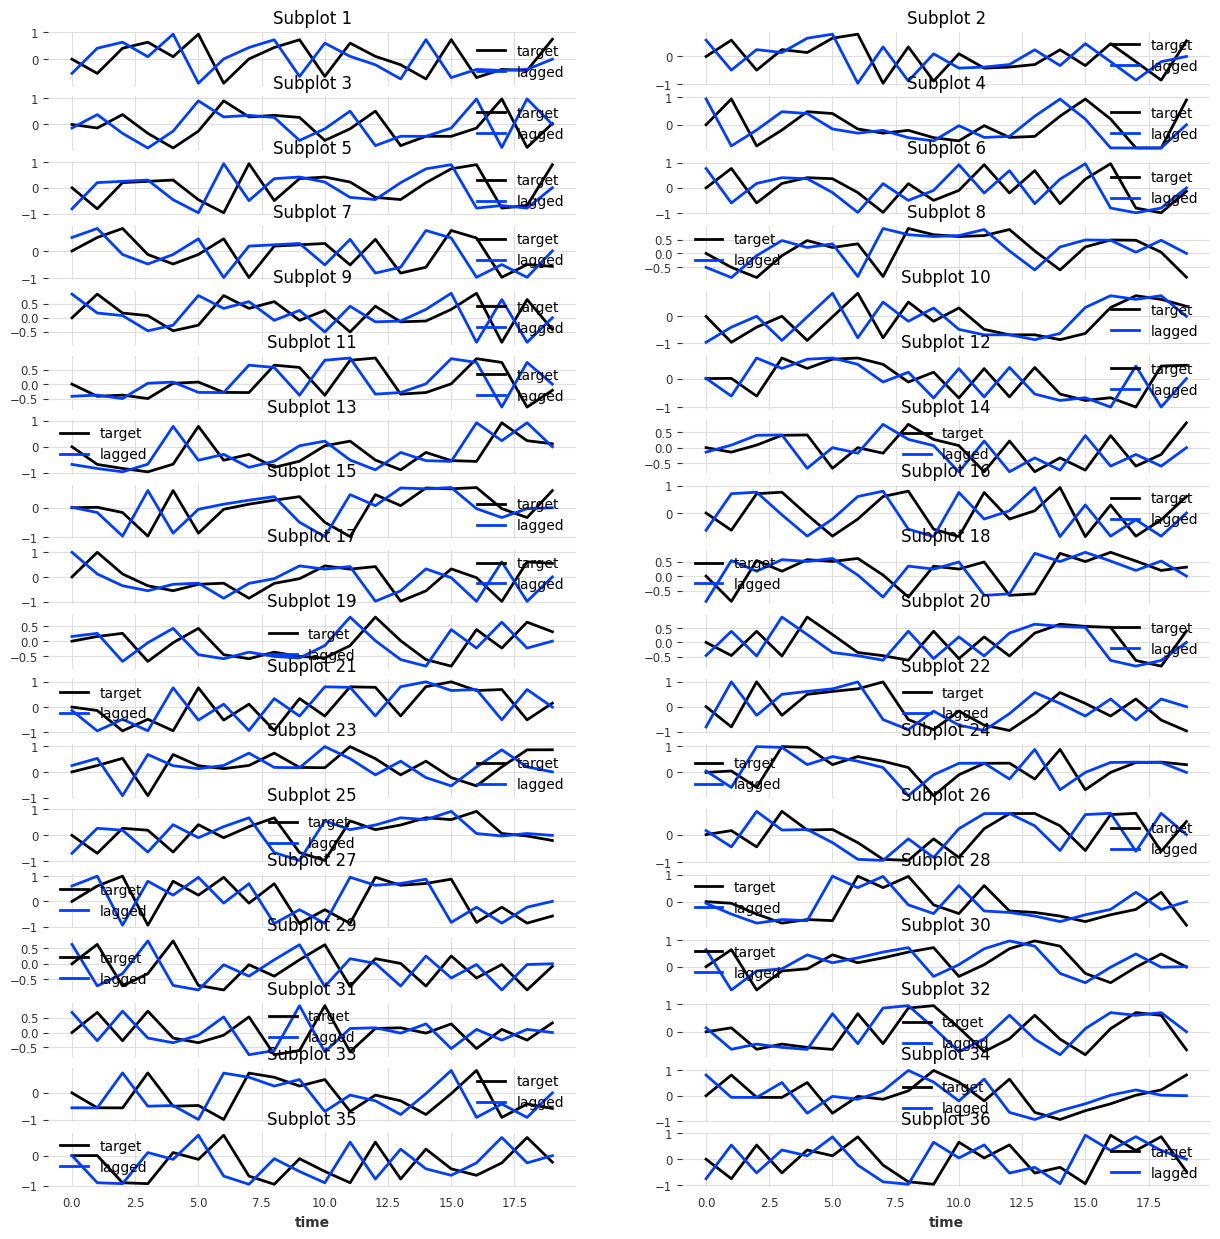

In [15]:
# plot target and lagged series in subplots 12 rows by 3 columns

columns = 2
rows = math.ceil(N_MULTI_SERIES / columns)

fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

for i in range(N_MULTI_SERIES):
    ax = axes[i // columns, i % columns]
    target_series[i].plot(label="target", ax=ax)
    lagged_series[i].plot(label="lagged", ax=ax)
    ax.set_title(f'Subplot {i+1}')
    ax.legend()

# plt.tight_layout()
plt.show()

In [ ]:
INPUT_CHUNK_LEN = 10
OUTPUT_CHUNK_LEN = 5
LOG_DIR= r"/workspaces/darts/examples/darts_logs/ts_generation"


def create_BlockRNNModel(n_epochs, sub_dir="default"):
    optimizer_kwargs = {"lr": 1e-4}

    log_dir = r"/workspaces/darts/examples/darts_logs/fit_files/logs"
    sub_dir = sub_dir
    tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

    pl_trainer_kwargs = {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
            "logger": tensorboard_logger,
        }

    return BlockRNNModel(
            model="LSTM",
            input_chunk_length=INPUT_CHUNK_LEN,
            output_chunk_length=OUTPUT_CHUNK_LEN,
            n_epochs=n_epochs,
            batch_size=16,
            optimizer_kwargs=optimizer_kwargs,
            random_state=seed,
            log_tensorboard=True,
            model_name="block_rnn_model",    
            pl_trainer_kwargs = pl_trainer_kwargs,
        )

In [ ]:
mapes = []
for n_epochs in [120, 150, 180, 210, 240, 270]:
    model_fit_files = create_BlockRNNModel(n_epochs=n_epochs)
    air_train = load_data_file("air_train.csv", train_data_path)
    model_fit_files.fit(series=air_train, val_series=air_val)
    pred = model_fit_files.predict(n=36, series=air_hist)
    mapes.append(mape(air_val, pred))
plot_mapes(mapes)